<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/ipynb/system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from enum import IntEnum
import collections
from statistics import mean
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=10, linewidth=200)
pd.options.mode.chained_assignment = None 

google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
data_dir = google_drive_dir + 'data/act_data/BTCUSDT/'

In [2]:
class Decision(IntEnum):
    SELL = -1
    WAIT = 0
    BUY = 1

# Trader

In [3]:
class BaseTrader:
    def __init__(self):
        pass

    def set_data(self, data):
        self.data = data



class PairTrader(BaseTrader):
    def __init__(self):
        self.balance = self.initial_money = 100
        self.quantity = 0
        self.trashold = .5
        self.trades = []
        self.profit = []
        self.time, self.times = 0, []

    def set_expert(self, pair_expert):
        self.expert = pair_expert

    def update(self, data):
        """Update candlesticks data, update expert.

        Args:
            data: Dictionary that maps timeframe name to new candlestick
            (Example: '1h' -> [...])
        """
        for timeframe, data in data.items():
            self.data[timeframe, 'History'].append(data)
            self.data[timeframe, 'History'].set_update_hash(time.time())
        self.expert.update()


    def act(self):
        estimation = self.expert.estimate()
        price = self.data['1h', 'History', 'Close'][-1]
        if estimation > self.trashold and self.balance > 0: # buy
            self.quantity = self.balance / price
            self.times.append(self.time)
            self.trades.append(('buy', self.quantity, price))
            self.balance = 0
        elif estimation < -self.trashold and self.quantity > 0: # sell
            self.balance = self.quantity * price
            self.times.append(self.time)
            self.trades.append(('sell', self.quantity, price))
            self.profit.append(self.evaluate_profit())
            self.quantity = 0
        self.time += 1


    def show_evaluation(self):
        if self.quantity > 0:
            self.balance = self.trades[-1][2] * self.quantity
            self.trades.pop()
            self.times.pop()
        print(f'{len(self.trades)} trades made')
        print(f'profit : {self.evaluate_profit():.2f} %')

    def evaluate_profit(self):
        return 100 * (self.balance - self.initial_money) / self.initial_money


# Data

In [4]:
class DataMaintainer:
    """Data Maintainer class for efficient data stream update.

    Args:
        _data: Dictionary that maps key to another DataMaintainer instance or deque.
        maxlen: Int. Maximum length of deque for columns.
    """

    def __init__(self, maxlen=2000):
        self._data = collections.defaultdict(DataMaintainer)
        self.maxlen = maxlen
        self.update_hash = None
    
    def __getitem__(self, keys):
        if not isinstance(keys, (tuple, list)):
            keys = (keys,)
        key, *other = keys
        if key not in self._data:
            raise KeyError(key)
        return self._data[key] if not other else self._data[key].__getitem__(other)

    def construct_location(self, keys):
        key, *other = keys
        return self._data[key] if not other else self._data[key].construct_location(other)

    def add(self, data=None, keys=[], location=None, maxlen=None):
        """Add data into the DataMaintainer.

        Args:
            data: Iterable. Contains columns to add.
            keys: Iterable. Contains keys for columns in same order.
            location: List. Contains subsequent keys for multikey access.
            maxlen: Int. Maximum length of deque for columns.
        """

        subunit = self.construct_location(location) if location else self
        subunit.maxlen = maxlen if maxlen is not None else self.maxlen
        for key, column in zip(keys, data if data is not None else [[] * len(keys)]):
            subunit._data[key] = collections.deque(column, maxlen=subunit.maxlen)
        return subunit

    def append(self, data, keys='auto'):
        """Append elements in data to deque specified by key.

        Args:
            data: Iterable. Elements to be added.
            keys: Iterable (optional). Contains keys for columns in same order.
                  By default keys are in the same order they were added.
        """
        keys = self._data.keys() if keys == 'auto' else keys
        for key, value in zip(keys, data):
            self._data[key].append(value)

    def set_update_hash(self, val):
        """Set hash representation of last time when data was updated"""
        self.update_hash = val

    def keys(self):
        return self._data.keys()

    def values(self):
        return self._data.values()

    def items(self):
        return self._data.items()

    def iterrows(self):
        for row in zip(*self.values()):
            return row

    def show(self, location='', show_last=10):
        maintainers, deques = [], []
        for key, obj in self._data.items():
            lst = maintainers if isinstance(obj, DataMaintainer) else deques
            lst.append((key, obj))
        
        for key, maintainer in maintainers:
                maintainer.show(f'{location}/{key}')
        print('\n' + location)
        for key, _ in deques:
            print(f'{key:>19}', end='')
        print('\n' * 2)
        cols = [list(val)[-show_last:] for key, val in deques]
        for attrs in zip(*cols):
            for val in attrs:
                print('{:>19.5f}'.format(val), end='')
            print()

# Experts

In [5]:
class BaseExpert:
    """Base Expert class for decision making."""

    def __init__(self):
        self.name = 'Base Expert'
        self._inner_experts = None
        self._weights = np.ones((len(self._inner_experts), 1))

    def set_experts(self, experts):
        self._inner_experts = experts
    
    def estimate(self):
        estimations = np.array([expert.estimate() for expert in self._inner_experts])
        # return estimations @ self._weights
        return np.mean(estimations)
    
    def update(self):
        for expert in self._inner_experts:
            expert.update()


class PairExpert(BaseExpert):
    """Expert class for handling specific trading pair.

    Args:
        base: String. Name of base currency.
        quote: String. Name of quote currency.
    """

    def __init__(self, base, quote):
        self.name = f'{base}/{quote} Expert'



class TimeFrameExpert(BaseExpert):
    """Expert class for handling specific timeframe.

    Args:
        timeframe: String. Name of timeframe (Example: '1h').
    """

    def __init__(self, timeframe):
        self.timeframe = timeframe
        self.name = f'{timeframe} Expert'



class RuleExpert(BaseExpert):
    """Expert class for handling specific trading rule.

    Args:
        indicators: List of BaseIndicator. Indicators to which rule is applied.
        rule: BaseRule. Trading rule that applies to indicators.
    """

    def __init__(self, indicators, rule):
        self._indicators = indicators
        self._rule = rule
        self.name = f'{self._rule.name} {str([indicator.name for indicator in self._indicators])}'

    def set_experts(self):
        raise SystemError('Do not call this method')

    def estimate(self):
        return self._rule.decide(*self._indicators)

    def update(self):
        for indicator in self._indicators:
            indicator.update()

# Indicators

In [6]:
class BaseIndicator:
    """Base Indicator Class
    
    Args:
        _data: DataMaintainer. If needed [_data] object will suply the indicator
            with necessary information, must have [self.name] key.
        _min_history: Int. Minimum number of candlestick required for state maintenance # ????????????
    """

    name = 'Base Indicator'

    def __init__(self, data):
        self._state = None
        self.update_hash = None
        self._history = data['History']

    def set_name(self):
        return f'{self.name} {self.get_parameters()}'

    def get_parameters(self):
        raise NotImplementedError()

    def init_state(self):
        """Calculate initial state"""
        raise NotImplementedError()

    def is_updated(self):
        return self.update_hash == self._history.update_hash

    def update(self):
        raise NotImplementedError()



class MovingAverageIndicator(BaseIndicator):
    name = 'MA'

    def __init__(self, data, length, source='Close', **kwargs):
        super().__init__(data, **kwargs)

        self.length = length
        self.source_name = source
        self.name = self.set_name()

        self._sma = SimpleMovingAverage(length=self.length)

        self._source = self._history[self.source_name]
        self.init_state()

    def init_state(self):
        for val in self._source:
            self.update(val)

    def get_state(self):
        return self._sma.get_state()
            
    def update(self, val=None):
        initialization = (val is not None)
        val = val if val is not None else self._source[-1]
        if not self.is_updated() or initialization:
            self.update_hash = self._history.update_hash
            self._sma.append(val)

    def get_parameters(self):
        return [self.length, self.source_name]



class RelativeStrengthIndexIndicator(BaseIndicator):
    name = 'RSI'

    def __init__(self, data, length, source='Close', **kwargs):
        super().__init__(data, **kwargs)

        self.length = length
        self.source_name = source
        self.name = self.set_name()

        self._up_smma = ExponentialMovingAverage(alpha=1/self.length)
        self._down_smma = ExponentialMovingAverage(alpha=1/self.length)

        self._source = self._history[self.source_name]
        self.init_state()

    def init_state(self):
        self._prev = 0
        for val in self._source:
            self.update(val)

    def get_state(self):
        rs = self._up_smma.get_state() / self._down_smma.get_state()
        rsi = 100 - 100 / (1 + rs)
        return rsi
            
    def update(self, val=None):
        initialization = (val is not None)
        val = val if val is not None else self._source[-1]
        if not self.is_updated() or initialization:
            self.update_hash = self._history.update_hash
            diff = val - self._prev
            up = max(val - self._prev, 0)
            down = max(self._prev - val, 0)
            self._up_smma.append(up)
            self._down_smma.append(down)
            self._prev = val
            
    def get_parameters(self):
        return [self.length, self.source_name]

# Rolling windows

In [7]:
class BaseRollingWindow:
    def __init__(self, length=None):
        self.length = length
        self._queue = collections.deque(maxlen=self.length)
        self._state = 0

    def get_state(self):
        return self._state



class SimpleMovingAverage(BaseRollingWindow):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def append(self, val):
        if len(self._queue) >= self.length:
            self._state -= self._queue.popleft() / self.length
        self._state += val / self.length
        self._queue.append(val)



class ExponentialMovingAverage(BaseRollingWindow):
    def __init__(self, alpha, **kwargs):
        super().__init__(**kwargs)
        self._alpha = alpha

    def append(self, val):
        self._state = (1 - self._alpha) * self._state + self._alpha * val

# Rules

In [8]:
class CrossoverState:
    """Helping class for tracking relative position between two lines.
    This class tracks which of two line is dominating (higher) and 
    how many steps ago they changed dominance (crossed).
    """

    def __init__(self):
        self._a = self._b = float('inf')
    
    def update(self, a, b):
        """Update relative positions of two lines, return a and b dominance"""
        if a > b:
            self._a += 1
            self._b = 0
        else:
            self._b += 1
            self._a = 0
        return self._a, self._b


class BaseRule:
    name = 'Base Rule'
    
    def __init__(self, patience=1):
        self._state = None
        self._patience = patience

    def update(self):
        raise NotImplementedError()
    
    def decide(self):
        raise NotImplementedError()



class BaseCrossoverRule(BaseRule):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)



class BaseTrasholdRule(BaseRule):
    def __init__(self, lower, upper, **kwargs):
        super().__init__(**kwargs)
        self._upper = upper
        self._lower = lower



class MovingAverageCrossoverRule(BaseCrossoverRule):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.cross = CrossoverState()

    def decide(self, slow, fast):
        buy, sell = self.cross.update(fast.get_state(), slow.get_state())
        if buy == self._patience:
            return Decision.BUY
        elif sell == self._patience:
            return Decision.SELL
        else:
            return Decision.WAIT



class RelativeStrengthIndexTrasholdRule(BaseTrasholdRule):
    def __init__(self, lower, upper, **kwargs):
        """
        Args:
            offset. Float in (0, 50). Trashold levels are defined as 50 +- offset"""
        super().__init__(lower, upper, **kwargs)
        self.lower_cross = CrossoverState()
        self.upper_cross = CrossoverState()

    def decide(self, rsi):
        val = rsi.get_state()
        buy, _ = self.lower_cross.update(self._lower, val)
        sell, _ = self.upper_cross.update(val, self._upper)
        if buy >= self._patience:
            return Decision.BUY
        elif sell >= self._patience:
            return Decision.SELL
        else:
            return Decision.WAIT

# Simulation

94 trades made
profit : 168.27 %


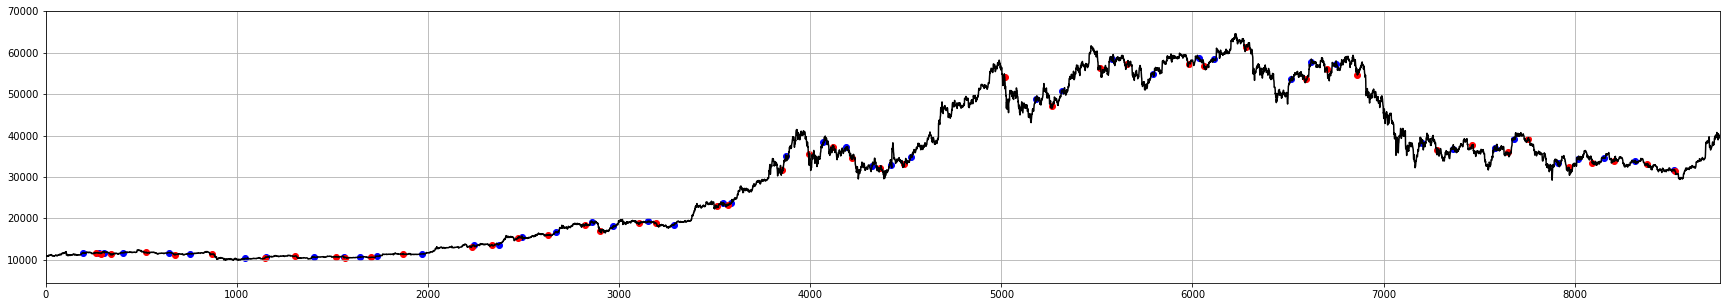

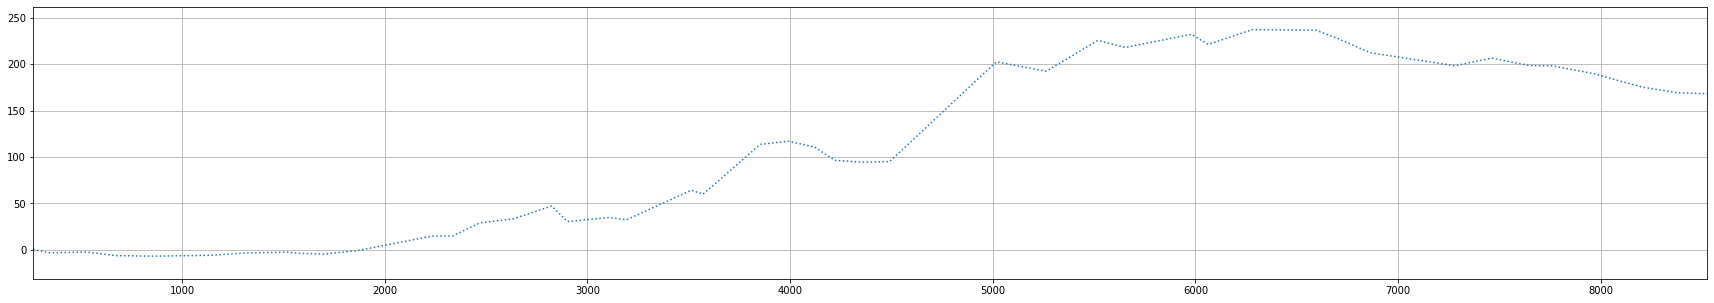

In [9]:
class Simulation:
    def simulate(self, history, n):
        self.prepare_data(history, n)
        trader = self.init_system()
        self.run(trader)

        plot(self.new_history['Close'], trader) 

    def prepare_data(self, history, n):
        self.pair = 'BTC/USDT'
        old_history, self.new_history = history.iloc[:-n], history.iloc[-n:-1]

        self.historical_data = DataMaintainer()
        self.historical_data.add(data=old_history.values.T, keys=list(history), location=[self.pair, '1h', 'History'])

    def init_system(self):
        trader = PairTrader()
        trader.set_data(self.historical_data[self.pair])

        indicator_data = self.historical_data[self.pair, '1h']

        # inds = [RelativeStrengthIndexIndicator(indicator_data, 14)]
        # rule = RelativeStrengthIndexTrasholdRule(lower=30, upper=70, patience=2)

        inds = [MovingAverageIndicator(indicator_data, 90),
                MovingAverageIndicator(indicator_data, 25)]
        rule = MovingAverageCrossoverRule(patience=5)
        rule_exp = RuleExpert(inds, rule)

        tf_exp = TimeFrameExpert('1h')
        pair_exp = PairExpert(*self.pair.split('/'))

        tf_exp.set_experts([rule_exp])
        pair_exp.set_experts([tf_exp])

        trader.set_expert(pair_exp)
        return trader

    def run(self, trader):
        for idx, row in self.new_history.iterrows():
            trader.update({'1h': row})
            trader.act()
        return trader.profit[-1] if trader.profit else 0



def plot(close, trader):
    n = len(close)
    trader.show_evaluation()

    buy, sell = trader.trades[::2], trader.trades[1::2]
    buy_time, sell_time = trader.times[::2], trader.times[1::2]

    config_plot(plt)

    plt.plot(range(n), close, color='black')
    plt.scatter(buy_time, [x[2] for x in buy], color='blue')
    plt.scatter(sell_time, [x[2] for x in sell], color='red')

    config_plot(plt)
    plt.plot(sell_time, trader.profit, linestyle=':')


def config_plot(plt):
    plt.figure(figsize = (30, 5))
    plt.margins(0, .1)
    plt.grid(True)


def load_history(filename):
    return pd.read_csv(data_dir + filename)


history = load_history('1h.csv')
n = 24 * 365
simulation = Simulation()
simulation.simulate(history, n)